### 期末报告：基于机器学习方法的混凝土强度预测（二）

| 学号 | 姓名 | 学院 | 专业 |
| :---: | :---: | :---: | :---: |
| 22312087 | 孔凡澍 | 建筑工程学院 | 桥梁与隧道工程 |

#### 项目简介：
* 混凝土是建筑行业与交通基础设施建设中最常用、最重要的材料，然而它具有不均匀、随机、配比复杂等特性，根据现有配合比去预测浇筑完成后混凝土强度非常困难。现有方法主要是通过开展材料试验，通过万能试验机测试混凝土的抗压强度 (Compressive Strength)，但显然成本高、周期长。
* 机器学习方法可以通过输入大量已知数据进行学习，并实现分类、回归、聚类、降维等功能。目前，国内外有大量学者在研究利用机器学习的混凝土强度预测的方法。
* 本项目参考多篇文献，采用UCI Machine Learning Repository中的‘ Concrete Compressive Strength ’数据集，利线性回归、CART、AdaBoost方法对混凝土强度进行预测。
* 本文件 ‘FinalReport2.ipynb’ 中，将重点进行基于Sklearn的数据多元线性回归分析、决策树回归分析。

#### 0. 导入必备的第三方库

In [1]:
# 基本数据分析库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 展示与配置相关库
from IPython.display import display

# 机器学习相关库
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score)

# 基本设置: Matplotlib中文字体与负号格式
config = {'font.family':'JBHGSS1'}
plt.rcParams.update(config)
plt.rcParams['axes.unicode_minus'] =False

#### 3.1 探索变量之间的相关性

In [2]:
# 导入原始数据
# 简便起见，直接将预处理后的数据导入并命名为'concrete'（相当于上一代码文件中的'concrete_pro'）
concrete = pd.read_csv(r'Concrete_Data_Pro.CSV') 
concrete_colX = list(concrete.columns) # 获取自变量字段名，留到后面使用
concrete_colX.pop(-1) # 删除索引为最后一个的元素 (因为Strength是因变量,是target)
concrete.head(7) # 展示数据

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
1,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
3,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
4,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03
5,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.70
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.45


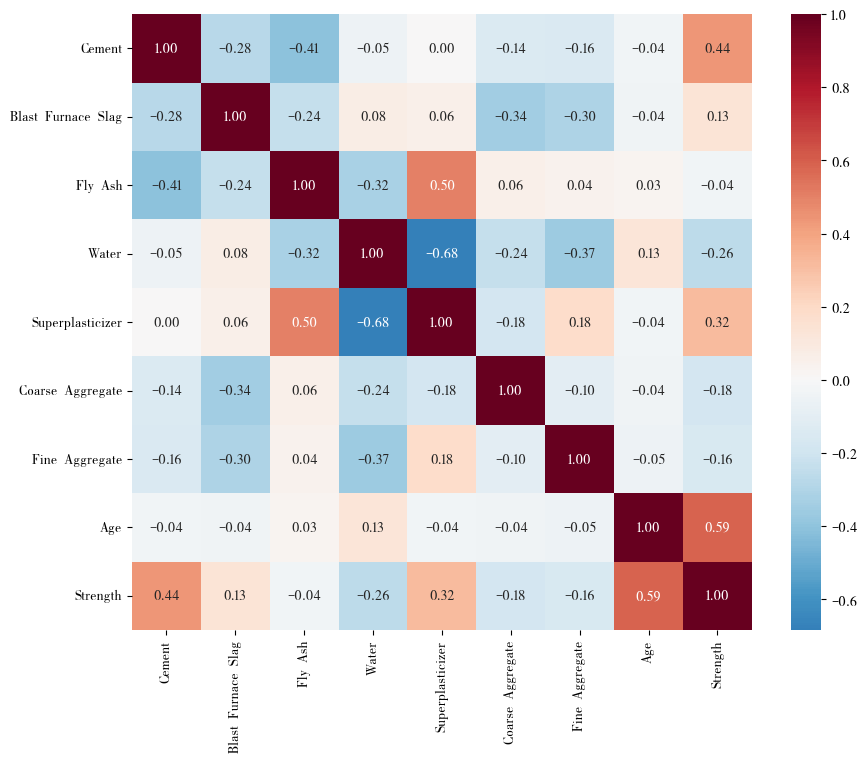

In [3]:
# 绘制各变量之间的Spearman相关系数热力图
# 注意许多变量很明显不符合正态分布，因此不能直接用Pearson相关分析
concrete_corr = concrete.corr(method='spearman') # 计算各变量之间的Spearman相关系数
fig = plt.figure(figsize=(10,8))
sns.heatmap(concrete_corr, annot=True, fmt='.2f', cmap="RdBu_r", center=0) # annot:是否标注，fmt为format，标注格式，center为色带中心点
plt.show()

#### 3.2 进行Spearman相关分析

In [4]:
# 再进行Spearman相关分析，给出具体结果（其它8个自变量与Stength因变量的相关性）
# 本小节与3.1节热力图验证有所重复,可作为补充内容
# 思路：循环遍历，依次对比前8个变量与Strength的关系,填充一个DataFrame以形成表格
spearman_df = pd.DataFrame(columns=concrete_colX, index=['Spearman_r','Spearman_p']) # 建立一个只有字段与索引的空DataFrame
for item in concrete_colX:
    spearman_r,spearman_p = stats.spearmanr(concrete[item], concrete['Strength']) # Pearson相关分析,返回相关系数与p值
    spearman_df[item]['Spearman_r'] = np.round(spearman_r,4) # 调整，保留4位小数
    spearman_df[item]['Spearman_p'] = spearman_p
display(spearman_df.round(3)) # 结果再次表明, Strength与单一自变量无直接线性相关关系

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
Spearman_r,0.4371,0.1338,-0.0379,-0.2615,0.3206,-0.1787,-0.1638,0.5871
Spearman_p,0.0,0.000024,0.233153,0.0,0.0,0.0,0.0,0.0


#### 3.3 多元线性回归分析: 提取、拆分与训练数据

In [5]:
# 格式转换,将data部分与target部分转化为Numpy矩阵
XMat = concrete[concrete_colX].values # 获取自变量数据集，其中.values属性将其获取为Numpy矩阵
yMat = concrete['Strength'].values # 获取因变量数据集

# 随机拆分为训练集与测试集，前者占8/9，后者占1/9
XL_train, XL_test, yL_train, yL_test = train_test_split(XMat, yMat, test_size=(1.0/9), random_state=0)

In [6]:
# 训练线性多元线性回归模型 (Multiple Linear Regression)
mulLR = LinearRegression() # 实例化一个线性回归器
mulLR.fit(XL_train,yL_train) # 训练线性回归器

LinearRegression()

#### 3.4 展示预测结果：Predict-Test散点图

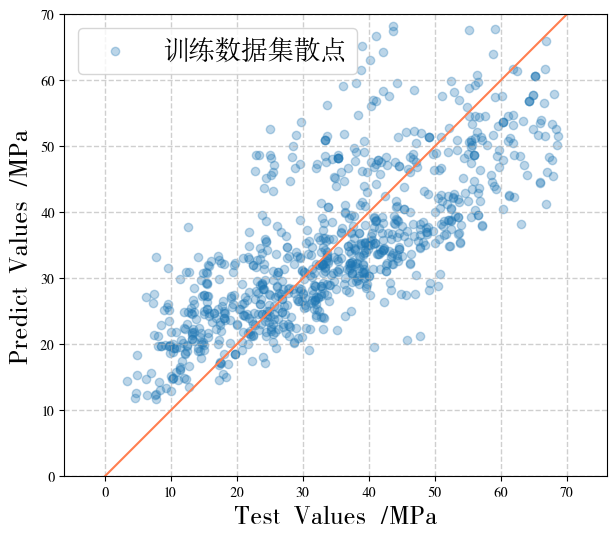

In [7]:
# 绘制【训练数据集】的Predict-Test散点图
# P-T散点图是指将实测值绘在x轴、预测值绘制在y轴的图示，观察散点与直线y=x偏离的程度可对模型准确程度进行评估
yL_train_predict = mulLR.predict(XL_train)
fig = plt.figure(figsize=(7,6))
plt.scatter(yL_train, yL_train_predict, alpha=0.3, label='训练数据集散点')
plt.plot(np.arange(0,80,10),np.arange(0,80,10), color='coral', linewidth = 1.5) # 绘制y=x参考线
# 绘图修饰
plt.axis('equal')
plt.grid(linestyle = '--', linewidth = 1, alpha = 0.6) 
plt.xlabel('Test Values /MPa', fontsize=19)
plt.ylabel('Predict Values /MPa', fontsize=19)
plt.xticks(np.arange(0,80,10)) # 设定纵横轴刻度
plt.yticks(np.arange(0,80,10)) 
plt.xlim(0,70) # 设置纵横轴显示范围
plt.ylim(0,70)
plt.legend(fontsize = 19)
plt.savefig(r'temp/graph5a.svg')
plt.show()

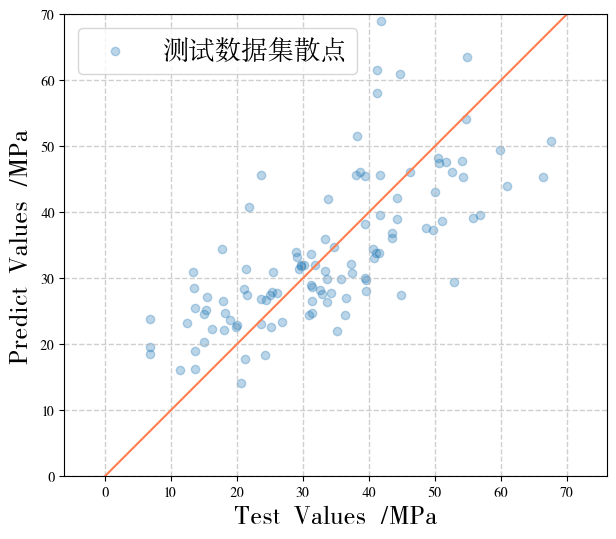

In [8]:
# 绘制【测试数据集】的Predict-Test散点图
# P-T散点图是指将实测值绘在x轴、预测值绘制在y轴的图示，观察散点与直线y=x偏离的程度可对模型准确程度进行评估
yL_test_predict = mulLR.predict(XL_test)
fig = plt.figure(figsize=(7,6))
plt.scatter(yL_test, yL_test_predict, alpha=0.3, label='测试数据集散点')
plt.plot(np.arange(0,80,10),np.arange(0,80,10), color='coral', linewidth = 1.5) # 绘制y=x参考线
# 绘图修饰
plt.axis('equal')
plt.grid(linestyle = '--', linewidth = 1, alpha = 0.6) 
plt.xlabel('Test Values /MPa', fontsize=19)
plt.ylabel('Predict Values /MPa', fontsize=19)
plt.xticks(np.arange(0,80,10)) # 设定纵横轴刻度
plt.yticks(np.arange(0,80,10)) 
plt.xlim(0,70) # 设置纵横轴显示范围
plt.ylim(0,70)
plt.legend(fontsize = 19)
plt.savefig(r'temp/graph5b.svg')
plt.show()

#### 3.5 展示预测结果：误差评价指标
* R^2指标，即决定系数：$\mathrm{R}^2=1-\frac{\sum_{i=1}^m\left(P_i-T_i\right)^2}{\sum_{i=1}^m\left(T_i-\overline{T}\right)^2}$
* MAE指标。即平均绝对值误差：$\mathrm{MAE}=\frac{\sum_{i=1}^m|P_i-T_i|}m$
* RMSE指标。即均方根误差：$\mathrm{RMSE}=\sqrt{\frac{\sum_{i=1}^m\left(P_i-T_i\right)^2}m}$
* 其中Pi和Ti分别为预测值与试验测试值

In [9]:
# 采用三个评价指标：R^2，MAE，RMSE对模型进行评价 (测试值)
# 思路：把print改为表格输出，会更清晰，其实也可以直接print出来
error_df = pd.DataFrame(columns=['R2','MAE','RMSE'], index=['LR_train','LR_test']) # 建立一个只有字段与索引的空DataFrame
# 逐个填充：调用Sklearn所包含的误差评估方法
error_df.loc['LR_train','R2'] = r2_score(yL_train,yL_train_predict).round(3)
error_df.loc['LR_train','MAE'] = mean_absolute_error(yL_train,yL_train_predict).round(3)
error_df.loc['LR_train','RMSE'] = np.sqrt(mean_squared_error(yL_train,yL_train_predict)).round(3)
error_df.loc['LR_test','R2'] = r2_score(yL_test,yL_test_predict).round(3)
error_df.loc['LR_test','MAE'] = mean_absolute_error(yL_test,yL_test_predict).round(3)
error_df.loc['LR_test','RMSE'] = np.sqrt(mean_squared_error(yL_test,yL_test_predict)).round(3)
display(error_df)  # 发现R值较低，两误差系数较大，说明线性回归预测精度较低

,R2,MAE,RMSE
LR_train,0.579,7.921,9.827
LR_test,0.504,7.871,9.732


#### 4.1 决策树回归：模型训练
* 由于线性回归的效果不佳，因此尝试其它算法进行回归预测，此处采用CART (分类与回归树)算法；
* 决策树回归是一种通过数据训练将空间分区、在区域内寻求误差最小，并不断生长新的枝叶来提高预测精度的算法；
* 决策树回归基本原理参考：https://zhuanlan.zhihu.com/p/42505644 。

In [10]:
# 训练决策树回归模型 (Decision Tree Regression)
mulDTR = DecisionTreeRegressor(max_depth=1000) # 初始化实例
mulDTR.fit(XL_train, yL_train)

DecisionTreeRegressor(max_depth=1000)

#### 4.2 展示CART预测结果：Predict-Test散点图

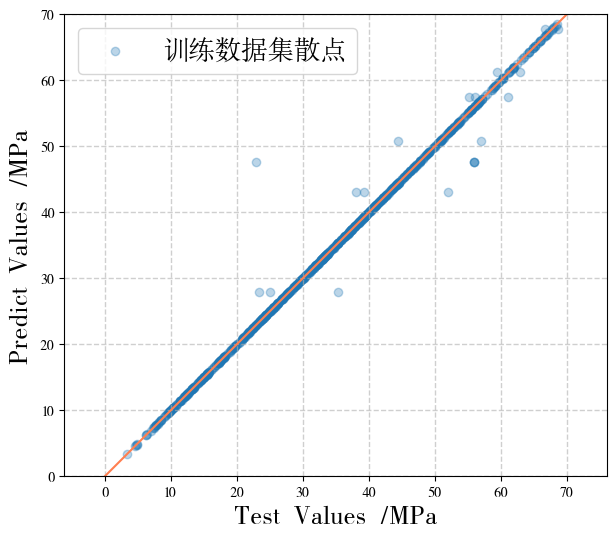

In [11]:
# 绘制【训练数据集】的Predict-Test散点图
# P-T散点图是指将实测值绘在x轴、预测值绘制在y轴的图示，观察散点与直线y=x偏离的程度可对模型准确程度进行评估
yT_train_predict = mulDTR.predict(XL_train)
fig = plt.figure(figsize=(7,6))
plt.scatter(yL_train, yT_train_predict, alpha=0.3, label='训练数据集散点')
plt.plot(np.arange(0,80,10),np.arange(0,80,10), color='coral', linewidth = 1.5) # 绘制y=x参考线
# 绘图修饰
plt.axis('equal')
plt.grid(linestyle = '--', linewidth = 1, alpha = 0.6) 
plt.xlabel('Test Values /MPa', fontsize=19)
plt.ylabel('Predict Values /MPa', fontsize=19)
plt.xticks(np.arange(0,80,10)) # 设定纵横轴刻度
plt.yticks(np.arange(0,80,10)) 
plt.xlim(0,70) # 设置纵横轴显示范围
plt.ylim(0,70)
plt.legend(fontsize = 19)
plt.savefig(r'temp/graph6a.svg')
plt.show()

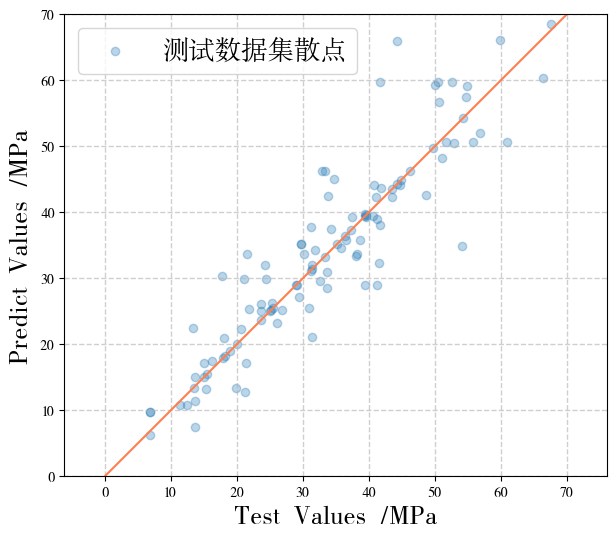

In [12]:
# 绘制【测试数据集】的Predict-Test散点图
# P-T散点图是指将实测值绘在x轴、预测值绘制在y轴的图示，观察散点与直线y=x偏离的程度可对模型准确程度进行评估
yT_test_predict = mulDTR.predict(XL_test)
fig = plt.figure(figsize=(7,6))
plt.scatter(yL_test, yT_test_predict, alpha=0.3, label='测试数据集散点')
plt.plot(np.arange(0,80,10),np.arange(0,80,10), color='coral', linewidth = 1.5) # 绘制y=x参考线
# 绘图修饰
plt.axis('equal')
plt.grid(linestyle = '--', linewidth = 1, alpha = 0.6) 
plt.xlabel('Test Values /MPa', fontsize=19)
plt.ylabel('Predict Values /MPa', fontsize=19)
plt.xticks(np.arange(0,80,10)) # 设定纵横轴刻度
plt.yticks(np.arange(0,80,10)) 
plt.xlim(0,70) # 设置纵横轴显示范围
plt.ylim(0,70)
plt.legend(fontsize = 19)
plt.savefig(r'temp/graph6b.svg')
plt.show()

#### 4.3 展示CART预测结果：误差评价指标
* R^2指标，即决定系数：$\mathrm{R}^2=1-\frac{\sum_{i=1}^m\left(P_i-T_i\right)^2}{\sum_{i=1}^m\left(T_i-\overline{T}\right)^2}$
* MAE指标。即平均绝对值误差：$\mathrm{MAE}=\frac{\sum_{i=1}^m|P_i-T_i|}m$
* RMSE指标。即均方根误差：$\mathrm{RMSE}=\sqrt{\frac{\sum_{i=1}^m\left(P_i-T_i\right)^2}m}$
* 其中Pi和Ti分别为预测值与试验测试值

In [13]:
# 同样采用与线性模型相同的评价指标
# 思路：把print改为表格输出，会更清晰，其实也可以直接print出来
error_df_cart = pd.DataFrame(columns=['R2','MAE','RMSE'], index=['DTR_train','DTR_test']) # 建立一个只有字段与索引的空DataFrame
# 逐个填充：调用Sklearn所包含的误差评估方法
error_df_cart.loc['DTR_train','R2'] = r2_score(yL_train,yT_train_predict).round(3)
error_df_cart.loc['DTR_train','MAE'] = mean_absolute_error(yL_train,yT_train_predict).round(3)
error_df_cart.loc['DTR_train','RMSE'] = np.sqrt(mean_squared_error(yL_train,yT_train_predict)).round(3)
error_df_cart.loc['DTR_test','R2'] = r2_score(yL_test,yT_test_predict).round(3)
error_df_cart.loc['DTR_test','MAE'] = mean_absolute_error(yL_test,yT_test_predict).round(3)
error_df_cart.loc['DTR_test','RMSE'] = np.sqrt(mean_squared_error(yL_test,yT_test_predict)).round(3)
display(error_df_cart) 

,R2,MAE,RMSE
DTR_train,0.994,0.122,1.132
DTR_test,0.818,3.862,5.895


#### 5.1 扩展应用：探究混凝土抗压强度随养护时间的变化规律
* 本小节的目标是：给定一种混凝土配比，预测它的抗压强度随时间变化的规律，用以指导实际工程中的构件制作。
* 为了提高CART模型预测精度，将上述‘ Concrete Compressive Strength ’中的全部有效数据进行训练。


In [14]:
# 选出两种混凝土配合比（探索性筛选：选择验证点较多的配合比）
display(concrete['Cement'].value_counts()) # 以cement为入手点，查看重复次数
print('----------------------------------')

# 筛选第一种配比
print('筛选第一种配比：')
display(concrete[(concrete['Cement']==425.0) & (concrete['Water']==153.5)]) # 探索发现这个配合比例较多
selected1 = concrete[concrete_colX].iloc[70,:].values # 选中技巧：相当于同时用字段名检索与索引坐标检索
selected1_index = [70,93,116,133,145] # 提取出该配比对应的行索引号，后面备用
display(selected1)
print('----------------------------------')
# 筛选第二种配比
print('筛选第二种配比：')
display(concrete[(concrete['Cement']==251.4) & (concrete['Superplasticizer']==5.8)])
selected2 = concrete[concrete_colX].iloc[245,:].values # 选中
selected2_index = [245,246,247,248,249] # 提取出该配比对应的行索引号
display(selected2)

Cement
425.0    20
251.4    15
446.0    14
310.0    14
331.0    13
         ..
133.1     1
145.9     1
236.9     1
184.0     1
260.9     1
Name: count, Length: 275, dtype: int64

----------------------------------
筛选第一种配比：


,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
70,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.40
75,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.40
78,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.40
93,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.20
98,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.20
101,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.20
116,425.0,106.3,0.0,153.5,16.5,852.1,887.1,28,60.29
121,425.0,106.3,0.0,153.5,16.5,852.1,887.1,28,60.29
124,425.0,106.3,0.0,153.5,16.5,852.1,887.1,28,60.29
133,425.0,106.3,0.0,153.5,16.5,852.1,887.1,56,64.30


array([425. , 106.3,   0. , 153.5,  16.5, 852.1, 887.1,   3. ])

----------------------------------
筛选第二种配比：


,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
245,251.4,0.0,118.3,188.5,5.8,1028.4,757.7,3,17.22
246,251.4,0.0,118.3,188.5,5.8,1028.4,757.7,14,29.93
247,251.4,0.0,118.3,188.5,5.8,1028.4,757.7,28,29.65
248,251.4,0.0,118.3,188.5,5.8,1028.4,757.7,56,36.97
249,251.4,0.0,118.3,188.5,5.8,1028.4,757.7,100,43.58
385,251.4,0.0,118.3,192.9,5.8,1043.6,754.3,3,11.98
398,251.4,0.0,118.3,192.9,5.8,1043.6,754.3,14,20.73
411,251.4,0.0,118.3,192.9,5.8,1043.6,754.3,28,33.27
424,251.4,0.0,118.3,192.9,5.8,1043.6,754.3,56,39.27
437,251.4,0.0,118.3,192.9,5.8,1043.6,754.3,100,40.15


array([ 251.4,    0. ,  118.3,  188.5,    5.8, 1028.4,  757.7,    3. ])

In [15]:
# 构造1-100天数据集:第一种配合比（Mix1）
time_test1 = np.tile(selected1,(100,1)) # 矩阵整体复制
time_test1[:,7] = np.arange(1,101,1) # 替换最后的Age列为1-100的整数

# 构造1-100天数据集:第二种配合比（Mix2）
time_test2 = np.tile(selected2,(100,1)) # 矩阵整体复制
time_test2[:,7] = np.arange(1,101,1) # 替换最后的Age列为1-100的整数

In [16]:
# 用全部concrete数据训练决策树回归模型 (Decision Tree Regression)
exDTR = DecisionTreeRegressor(max_depth=1000) # 初始化实例
exDTR.fit(XMat, yMat) # 训练模型

DecisionTreeRegressor(max_depth=1000)

In [17]:
# 预测两组固定配合比Mix1与Mix2的结果
time_test_predict1 = exDTR.predict(time_test1)
time_test_predict2 = exDTR.predict(time_test2)

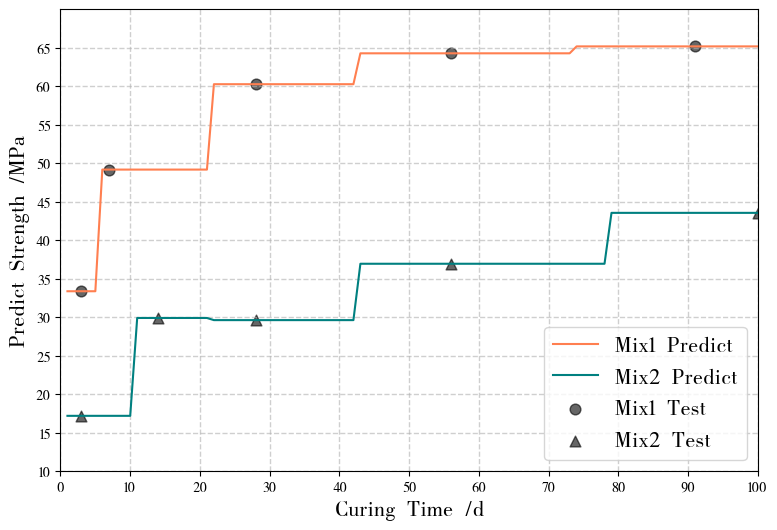

In [18]:
# 绘制混凝土抗压随时间变化的预测图
fig = plt.figure(figsize=(9,6))
plt.plot(np.arange(1,101,1),time_test_predict1,color='coral', linewidth = 1.5, label = 'Mix1 Predict')
plt.plot(np.arange(1,101,1),time_test_predict2,color='teal', linewidth = 1.5, label = 'Mix2 Predict')

# 绘制实测数据散点
mix1_age = np.array([concrete['Age'][i] for i in selected1_index]) 
mix1_strength = np.array([concrete['Strength'][i] for i in selected1_index])    
mix2_age = np.array([concrete['Age'][i] for i in selected2_index])  
mix2_strength = np.array([concrete['Strength'][i] for i in selected2_index])  # 列表生成式提取散点
plt.scatter(mix1_age,mix1_strength, color='k', alpha=0.6, marker='o', s=60, label='Mix1 Test')
plt.scatter(mix2_age,mix2_strength, color='k', alpha=0.6, marker='^', s=60, label='Mix2 Test') # 绘制散点
# 绘图修饰
plt.legend(fontsize = 16)
plt.xlabel('Curing Time /d', fontsize = 16)
plt.ylabel('Predict Strength /MPa', fontsize = 16)
plt.grid(linestyle = '--', linewidth = 1, alpha = 0.6) 
plt.xticks(np.arange(0,101,10)) # 设定纵横轴刻度
plt.yticks(np.arange(0,70,5)) 
plt.xlim(0,100) # 设置纵横轴显示范围
plt.ylim(10,70)
plt.savefig(r'temp/graph7.svg')
plt.show()

#### 5.2 扩展应用：利用CART模型对全新数据集进行回归预测
* 在UCI Machine Learning Repository中，还存在‘ Concrete Slump Test ’数据集，该数据集有103个数据，同样包括8个特征与抗压强度数据，因此可以用作新数据集来评估CART预测模型的性能；
* 为了提高CART模型预测精度，同样将上述‘ Concrete Compressive Strength ’中的全部有效数据进行训练（直接使用exDTR模型）。


In [19]:
# 导入扩展数据集
concrete_ex = pd.read_csv(r'Slump_Test.csv') 
display(concrete_ex.describe())

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.00000,103.000000
mean,52.000000,229.894175,77.973786,149.014563,197.167961,8.539806,883.978641,739.604854,18.048544,49.61068,36.039417
std,29.877528,78.877230,60.461363,85.418080,20.208158,2.807530,88.391393,63.342117,8.750844,17.56861,7.838232
min,1.000000,137.000000,0.000000,0.000000,160.000000,4.400000,708.000000,640.600000,0.000000,20.00000,17.190000
25%,26.500000,152.000000,0.050000,115.500000,180.000000,6.000000,819.500000,684.500000,14.500000,38.50000,30.900000
50%,52.000000,248.000000,100.000000,164.000000,196.000000,8.000000,879.000000,742.700000,21.500000,54.00000,35.520000
75%,77.500000,303.900000,125.000000,235.950000,209.500000,10.000000,952.800000,788.000000,24.000000,63.75000,41.205000
max,103.000000,374.000000,193.000000,260.000000,240.000000,19.000000,1049.900000,902.000000,29.000000,78.00000,58.530000


In [20]:
# 新数据集数据预处理：规范化

# 删除‘No’列：可能引起误导
if ('No' in concrete_ex.columns.values):
    del concrete_ex['No']

# 删除不关注的特征：、坍落度、流动性
if ('SLUMP(cm)' in concrete_ex.columns.values) and (('FLOW(cm)' in concrete_ex.columns.values)): # 防止多次运行报错
    concrete_ex.drop(['SLUMP(cm)','FLOW(cm)'], axis=1, inplace=True) # 删除坍落度、流动性两列，因为不关注这些性能

# 添加Age字段：因为Slump数据集中所有抗压强度均是在28天时测试的   
if ('Age' in concrete_ex.columns.values): # 防止多次运行报错
    pass
else:
    concrete_ex.insert(7, 'Age', [28]*len(concrete_ex)) # 技巧：在Dataframe指定位置插入一列，并且构造重复列表

# 更改字段名称与Concrete一致
concrete_ex.columns = concrete.columns 
display(concrete_ex.describe())

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.0,103.000000
mean,229.894175,77.973786,149.014563,197.167961,8.539806,883.978641,739.604854,28.0,36.039417
std,78.877230,60.461363,85.418080,20.208158,2.807530,88.391393,63.342117,0.0,7.838232
min,137.000000,0.000000,0.000000,160.000000,4.400000,708.000000,640.600000,28.0,17.190000
25%,152.000000,0.050000,115.500000,180.000000,6.000000,819.500000,684.500000,28.0,30.900000
50%,248.000000,100.000000,164.000000,196.000000,8.000000,879.000000,742.700000,28.0,35.520000
75%,303.900000,125.000000,235.950000,209.500000,10.000000,952.800000,788.000000,28.0,41.205000
max,374.000000,193.000000,260.000000,240.000000,19.000000,1049.900000,902.000000,28.0,58.530000


In [21]:
# 预测模型
X_ex = concrete_ex[concrete_colX].values # 别忘了将DataFrame转换为Numpy数组
y_ex = concrete_ex['Strength'].values
y_ex_predict = exDTR.predict(X_ex) # 预测模型

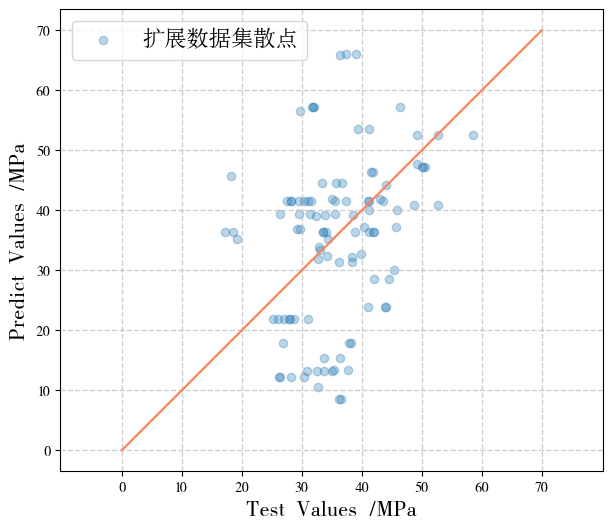

In [22]:
# 绘制【扩展测试数据集】的Predict-Test散点图
# P-T散点图是指将实测值绘在x轴、预测值绘制在y轴的图示，观察散点与直线y=x偏离的程度可对模型准确程度进行评估
fig = plt.figure(figsize=(7,6))
plt.scatter(y_ex, y_ex_predict, alpha=0.3, label='扩展数据集散点')
plt.plot(np.arange(0,80,10),np.arange(0,80,10), color='coral', linewidth = 1.5) # 绘制y=x参考线
# 绘图修饰
plt.axis('equal')
plt.grid(linestyle = '--', linewidth = 1, alpha = 0.6) 
plt.xlabel('Test Values /MPa', fontsize=16)
plt.ylabel('Predict Values /MPa', fontsize=16)
plt.xticks(np.arange(0,80,10)) # 设定纵横轴刻度
plt.yticks(np.arange(0,80,10)) 
plt.xlim(0,70) # 设置纵横轴显示范围
plt.xlim(0,70)
plt.legend(fontsize = 16)
plt.savefig(r'temp/graph8.svg')
plt.show()

In [23]:
# 同样采用与线性模型相同的评价指标
# 思路：把print改为表格输出，会更清晰，其实也可以直接print出来
error_df_ex = pd.DataFrame(columns=['R2','MAE','RMSE'], index=['Ex_test']) # 建立一个只有字段与索引的空DataFrame
# 逐个填充：调用Sklearn所包含的误差评估方法
error_df_ex.loc['Ex_test','R2'] = r2_score(y_ex, y_ex_predict).round(3)
error_df_ex.loc['Ex_test','MAE'] = mean_absolute_error(y_ex, y_ex_predict).round(3)
error_df_ex.loc['Ex_test','RMSE'] = np.sqrt(mean_squared_error(y_ex, y_ex_predict)).round(3)
display(error_df_ex)

,R2,MAE,RMSE
Ex_test,-2.073,10.896,13.673
